# Purpose
The purpose of this notebook is to generate Figure 6.

# Preliminaries

## load packages

In [1]:
%matplotlib inline
%autosave 60
%load_ext autoreload
%autoreload 2

#filesystem
import os
import glob
from tqdm import tqdm

#plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from dateutil import rrule
import matplotlib.colors as mcolors

#data
import random
from datetime import timedelta
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import networkx as nx
import community
from scipy.stats import spearmanr

#custom
from src import rfid 
from src import plot
from src import rfid 
from src import preprocess
from src import parameters as prms
from src import timestamps as tmp

Autosaving every 60 seconds


## paths

In [2]:
# project root - to reproduce, just change root to the full path to wild-mus-vocal-ecology
root = '/path/to/wild-mus-vocal-ecology'

# paths to rfid reading directories (each contains a directory for meets, stays, and box events)
moth_rfid = os.path.join(root, 'data', 'rfid') # path to rfid data

# path to vocal events (both aligned and non-aligned)
vocal_events_path = os.path.join(root,'data', 'segments', 'vocal_events')

# path to social vocal correlations made below in cell 5, if they exist
# note coi stands for "co-occupancy index", the measure of how much time mice spend together
coi_vocal_correlations_path = os.path.join(root, 'data', 'coi_vocal_correlations')

# path to adult phenotypes (with sex)
sexes_path = os.path.join(root, 'data', 'phenotypes', 'sexes.csv')

# audiomoth deployment dates
deployment_dates = os.path.join(root, 'parameters', 'json_files','deployment_dates.json')

# cartoon for panel A
path_to_cartoon = os.path.join(root, 'parameters', 'images','cartoon_panel_v1.jpeg')

# Get transponder and sex data

In [3]:
# make a dictionary mapping transponder ID to sex
sexes = pd.read_csv(sexes_path, low_memory=False)
sex_dict = sexes.set_index('transponder_ID')['Sex'].to_dict()

# color them
sex_colors = {}
sex_colors['M'] = 'tomato'
sex_colors['F'] = 'skyblue'
sex_colors[float('NaN')] = 'grey'

# Get the raw data

In [1]:
# meets 2022-2023
print('getting meets...')
meets = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(moth_rfid, 'mouse_meets', '*.feather')) if int(os.path.basename(i)[:8]) >= 20220601])
meets = preprocess.raw_data_from_cloud_of_mice(meets, df_type='meets')

# stays 2022-2023
print('getting stays 2022-2023...')
stays = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(moth_rfid,  'mouse_stays', '*.feather')) if int(os.path.basename(i)[:8]) >= 20220601])
stays = stays.rename(columns={'box_number':'box'})
stays = preprocess.raw_data_from_cloud_of_mice(stays, df_type='stays')
stays = stays[stays['time_in_secs'] > 0] # drop the 4 stays with negative stay length

#vocal events - all recordings
print('getting aligned vocal events 2022-2023...')
v_events_aligned = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(vocal_events_path, '*time-adjusted.csv'))])
v_events_aligned = preprocess.raw_data_from_cloud_of_mice(v_events_aligned, df_type='vocal_events')

#coi-vocal correlatons
if os.path.exists(coi_vocal_correlations_path) and len(os.listdir(coi_vocal_correlations_path)) != 0:
    print('getting mouse events for audiomoth recorded boxes 2022-2023...')
    coi_vocal_events = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(coi_vocal_correlations_path, '**/*.csv'))])
    make_coi_vocal_correlations = False
    
else:
    print("It looks like you didn't make any coi-vocal correlation tables - you will make them below.")
    if not os.path.exists(coi_vocal_correlations_path):
        os.mkdir(coi_vocal_correlations_path)
    make_coi_vocal_correlations = True

print('Done.')

In [5]:
# define audio dataset start and end
dataset_start = pd.to_datetime('2022-08-01 00:00:00')
dataset_end = pd.to_datetime('2023-12-02 23:59:59') 

#subset by start and end, add some useful columns (sex, time in useful units)
stays = stays[(stays['entry_time'] >= dataset_start) & (stays['exit_time'] <= dataset_end)]
meets = meets[(meets['overlap_start_time'] >= dataset_start) & (meets['overlap_start_time'] <= dataset_end)]
meets['sex_id1'], meets['sex_id2'] = meets['id1'].astype(int).map(sex_dict), meets['id2'].astype(int).map(sex_dict)
stays['sex'] = stays['transponder_id'].astype(int).map(sex_dict)
stays['time_in_secs'] = stays['time_in_secs'].astype(float)
stays['time_in_minutes'] = stays['time_in_secs']/(60)

# these are the only boxes 2022-2023
stays = stays[stays['box'].isin(np.arange(2, 41, 2))] 
meets = meets[meets['box'].isin(np.arange(2, 41, 2))] 

# minimum stay to consider for the purpose of this figure 
min_stay = 0.01

# Make COI-vocal correlations

## set the parameters

In [2]:
if make_coi_vocal_correlations:
    print('Setting parameters for coi-vocal correlaton analysis.')
    
    # randome state
    random_state = 123456

    # the time window over which to calculate co-occupancy index in hours
    analysis_window = 12

    # minimum number of meets to calculate a spearman correlation between vocalization and meeting time
    min_meets = 5

    # where the csvs will be saved
    save_dir = os.path.join(coi_vocal_correlations_path, 'coi-vocal-correlation_'+str(analysis_window)+'hr-window_'+str(prms.get_timestamp()))
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    # get the deployments for which you have vocalization predictions
    deployments = v_events_aligned['deployment'].unique() 

    # get the recording windows fro each box that was recording
    recording_windows = prms.load_json(os.path.join(root, 'parameters', 'json_files','recordings_by_box_20240618'))

    # make time columns datetime
    date_cols_stays = ['entry_time', 'exit_time']
    date_cols_v_events = ['audiomoth_timestamp_datetime', 'audiomoth_start_seconds_adjusted', 'audiomoth_stop_seconds_adjusted']
    date_cols_meets = ['overlap_start_time', 'overlap_end_time', 'entry1', 'entry2', 'exit1', 'exit2']
    stays[date_cols_stays] = stays[date_cols_stays].apply(pd.to_datetime)
    v_events_aligned[date_cols_v_events] = v_events_aligned[date_cols_v_events].apply(pd.to_datetime)
    meets[date_cols_meets] = meets[date_cols_meets].apply(pd.to_datetime)
    
    # make IDs strings
    stays['transponder_id'] = stays['transponder_id'].astype(str)
    meets['id1'] = meets['id1'].astype(str)
    meets['id2'] = meets['id2'].astype(str)
    print('Done.')

else:
    print("Looks like you already calculated the coi-vocal correlations -- no parameters have been changed")

## run the analysis
- this will take about 24 hours (about 1 hour per deployment)

In [3]:
if make_coi_vocal_correlations:

    for deployment in sorted(deployments):
        
        rfid.calculate_coi_vocal_correlations(root = root, 
                                              deployment = deployment, 
                                              recording_windows = recording_windows, 
                                              all_meets = meets, 
                                              v_events = v_events_aligned, # NB use audio timestamps that have been aligned to RFID clock
                                              stays = stays, 
                                              analysis_window = analysis_window,
                                              sex_dict = sex_dict, 
                                              save_dir = save_dir, 
                                              random_state = random_state,
                                              verbose = False, 
                                              min_meets = min_meets)
        print('Done.')
        
else:
    print("Looks like you already calculated the coi-vocal correlations \nIf you want to run it again, set make_coi_vocal_correlations = True")
        


# Load the data in the csvs you just made

In [4]:

# where the csvs were saved
coi_vocal_correlations_path = 'path/to/csvs'
if os.path.exists(coi_vocal_correlations_path) and len(os.listdir(coi_vocal_correlations_path)) != 0:
    print('getting COI vocal correlations...')

    # collect the data frames and add deployments for each
    dfs = []
    for path in sorted(glob.glob(os.path.join(coi_vocal_correlations_path, '*.csv'))):
        deployment = os.path.split(path)[-1].split('.')[0]
        df = pd.read_csv(path)
        df['deployment'] = deployment
        dfs.append(df)

    # combine them
    coi_vocal_df = pd.concat(dfs)

    # add useful meta-data
    coi_vocal_df = coi_vocal_df.reset_index(drop=True)
    coi_vocal_df['vocs_count'] = coi_vocal_df['squeak_counts'] + coi_vocal_df['USV_counts']
    coi_vocal_df['vocs_present'] = coi_vocal_df['vocs_count'] != 0
    coi_vocal_df['squeaks_present'] = coi_vocal_df['squeak_counts'] != 0
    coi_vocal_df['USV_present'] = coi_vocal_df['USV_counts'] != 0
    coi_vocal_df['pair_ID'] = [('_').join(sorted([str(mouse1),str(mouse2)])) for mouse1, mouse2 in zip(coi_vocal_df['id1'], coi_vocal_df['id2'])]
    coi_vocal_df['overlap_start_time'] = pd.to_datetime(coi_vocal_df['overlap_start_time'])
    coi_vocal_df['season'] = [tmp.get_season_from_date(i) for i in coi_vocal_df['overlap_start_time']]
    coi_vocal_df['time_in_hours'] = coi_vocal_df['time_in_secs']/(60*60)
    coi_vocal_df['sex1'], coi_vocal_df['sex2'] = coi_vocal_df['id1'].astype(int).map(sex_dict), coi_vocal_df['id2'].astype(int).map(sex_dict)
    coi_vocal_df['meeting_type'] = [str(i)+str(j) if not (j==float('NaN') or i==float('NaN')) else float('NaN') for i, j in zip(coi_vocal_df['sex1'], coi_vocal_df['sex2'])]
    coi_vocal_df['meeting_type'] = coi_vocal_df['meeting_type'].map({'MM':'MM', 'FF':'FF', 'MF':'MF', 'FM':'MF'})

    # get the pair-specific data 
    # all of these columns describe pairs, do not differ from meeting to meeting within a pair
    coi_vocal_df_by_pair = coi_vocal_df.groupby('pair_ID').agg({'shuffled_squeak_counts-next_COI_pre_correlation':'first', 
                                         'squeak_counts-next_COI_pre_correlation':'first', 
                                         'USV_counts-next_COI_pre_correlation':'first', 
                                          'shuffled_USV_counts-next_COI_pre_correlation':'first', 
                                         'season':'first', 
                                         'meeting_type':'first', 
                                         'num_meets':'first'})
else:
    print("It doesn't seem like you succesfully made the mouse_events files -- is the path correct?")

print('Done.')

# Make the figure

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_19292/958536866.py:185: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes["R"].set_xticklabels(season_order, rotation=90)


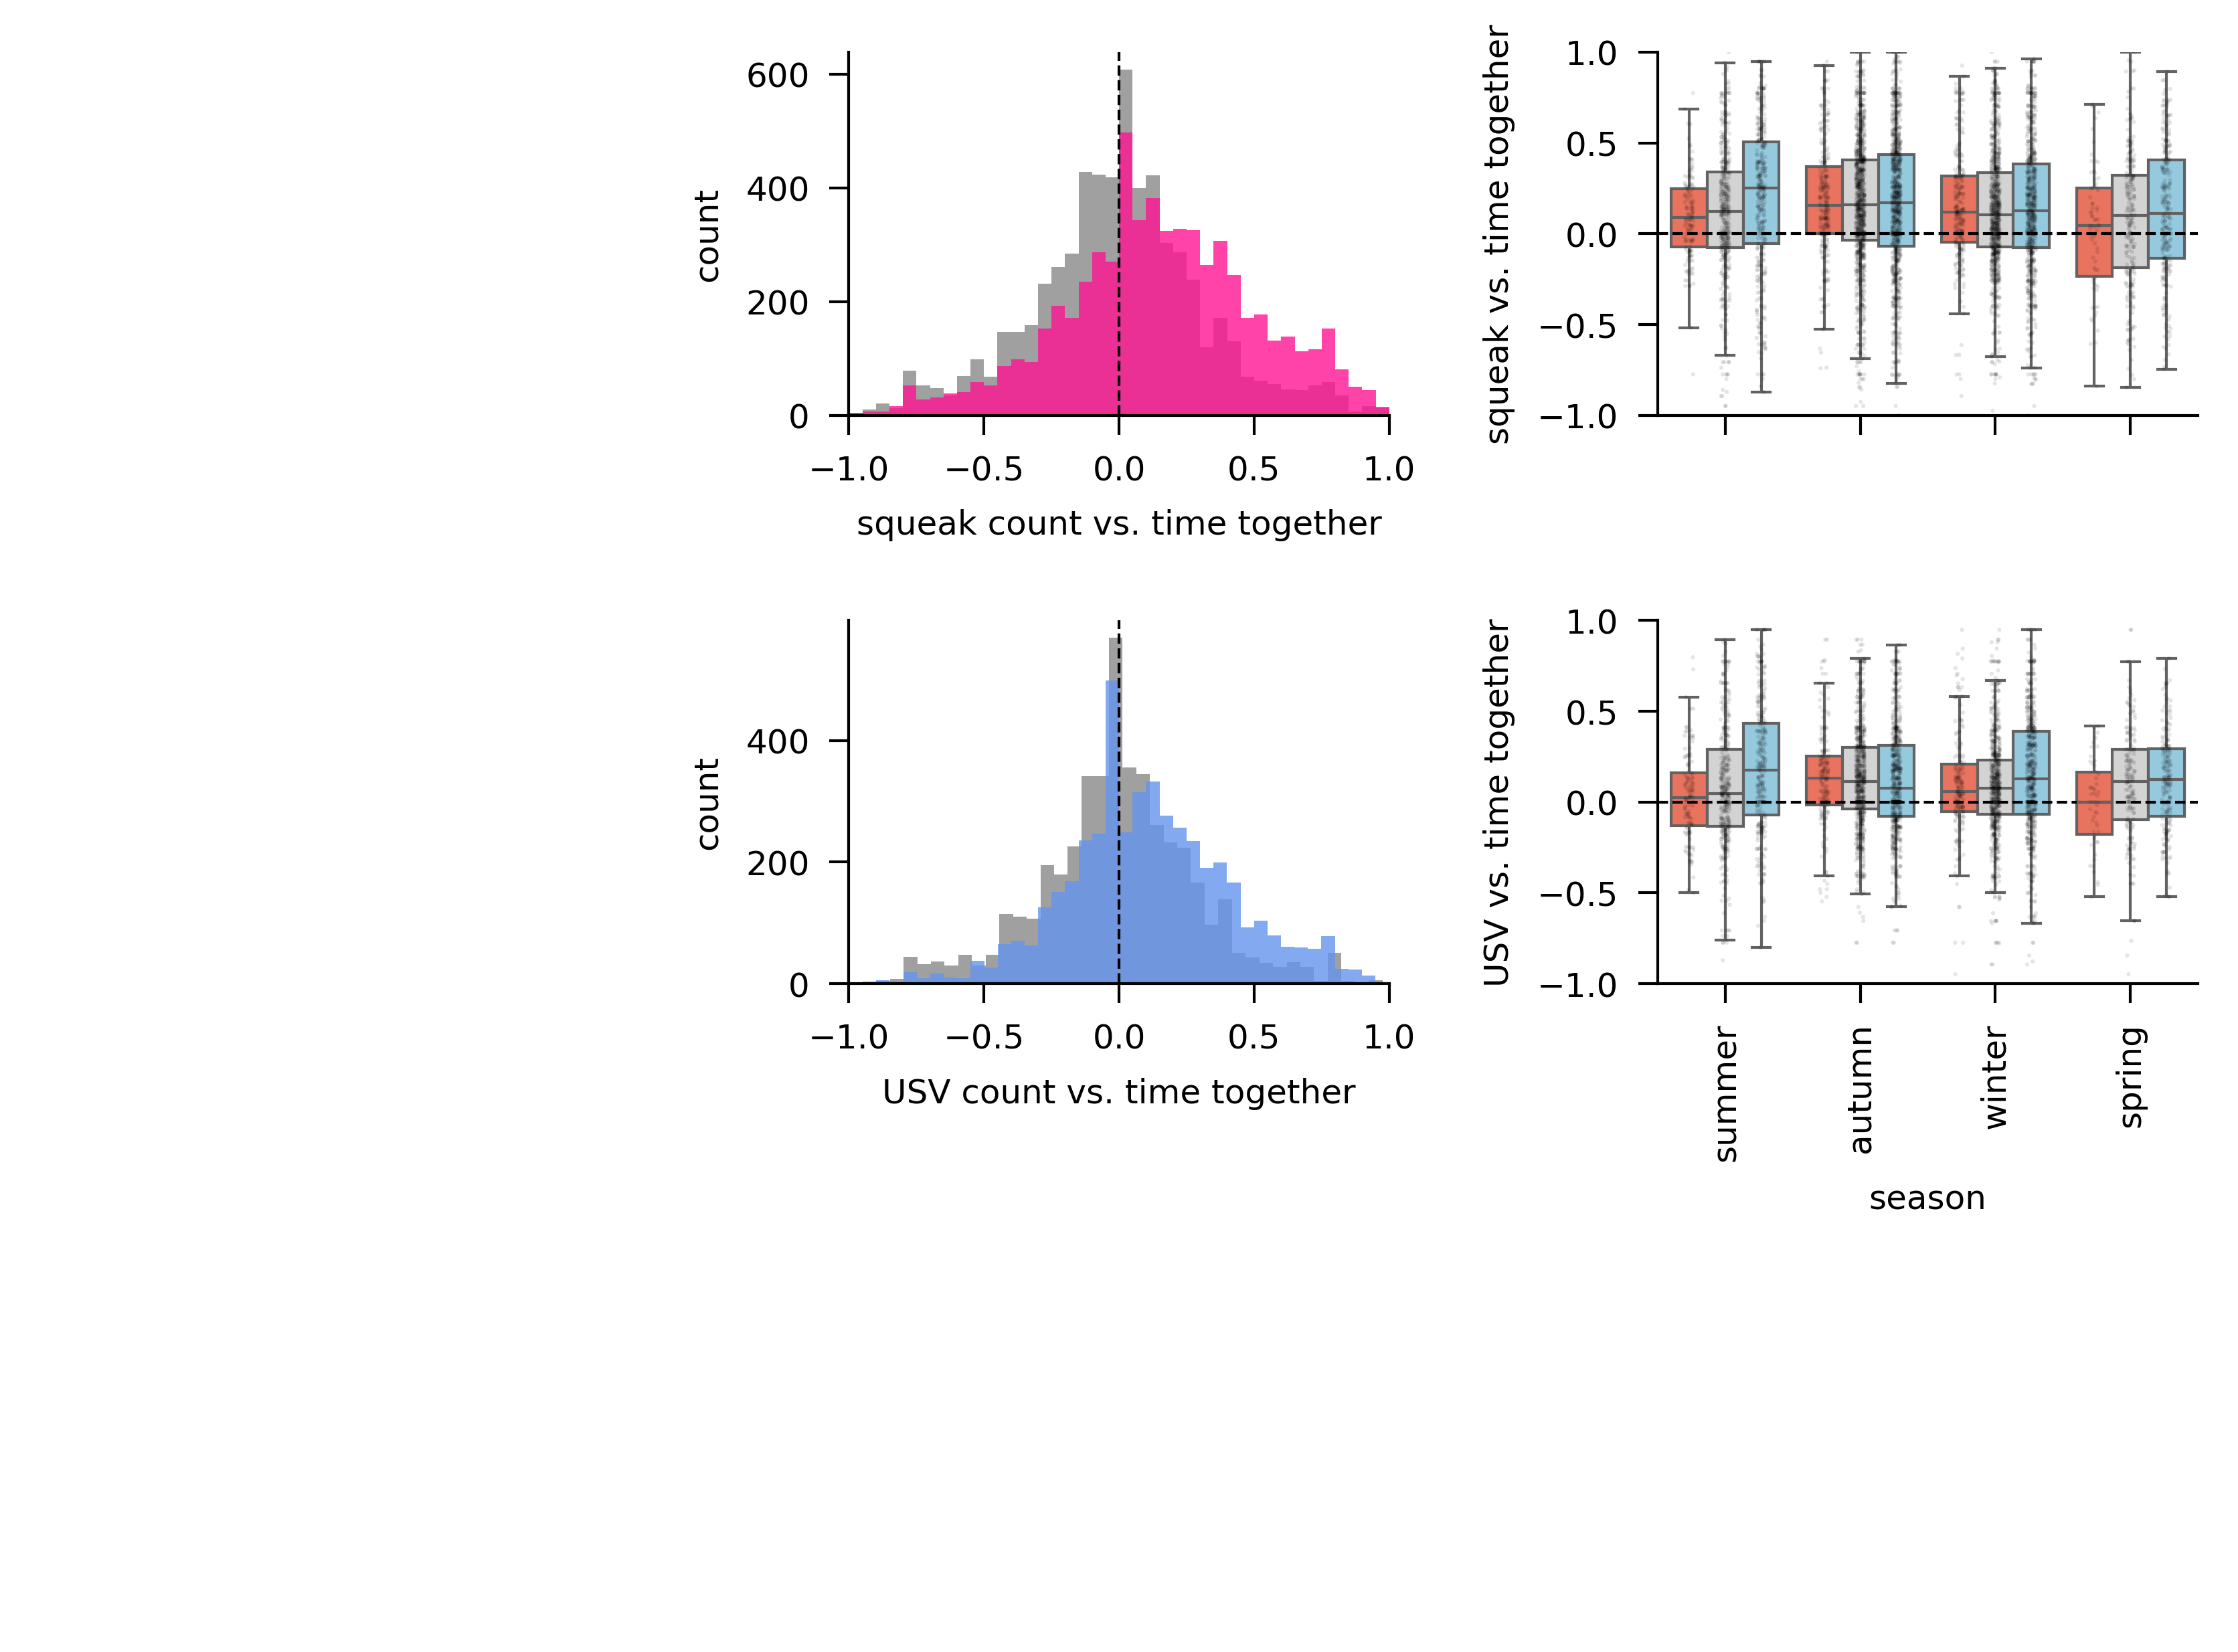

In [10]:
# save or not
save = False
path_to_save = ''


##################################################################################################

fig, axes = plt.subplot_mosaic(mosaic=".MMNNOO.;"\
                                      ".MMQQRR.;"\
                                      ".^^^^^^.",

                               figsize=[8.5,4], 
                               
                               constrained_layout=True,
                               gridspec_kw={"height_ratios": [0.5,0.5,0.5],
                                           "width_ratios": [1, 0.25,0.25,0.25, 0.25, 0.25,0.25, 1]},
                               dpi=600)

#plot parameters
tick_label_fontsize = 6
axis_label_fontsize = 9
title_label_fontsize = 12
num_ticks = 10 # for panel F x-axis
dot_size = .5
dot_alpha = .75
spine_width = 0.5
meeting_type_order = ['MM', 'MF', 'FF']
meeting_type_palette = {'FF':'skyblue', 'MF':'lightgrey', 'MM':'tomato'}
season_order = ['summer', 'autumn', 'winter', 'spring']
sex_palette = {'M':'tomato', 'F':'skyblue'}

#hide unused axes
axes["^"].axis('off')
axes["M"].axis('off')

# get the first value of these columns for each pair
# all of these describe pairs, do not differ from meeting to meeting within a pair

#################################################################################################
#panel M - cartoon - just add this by hand in illustrator
#################################################################################################
    
# image = Image.open(path_to_cartoon)
# axes["M"].imshow(image)
# axes["M"].axis('off')  # Optionally turn off the axis
# left = 0
# bottom = 0.3
# width = 0.5
# height = 0.5
# axes["M"].set_position([left, bottom, width, height])  # Adjust the size

##################################################################################################
# panel N - histogram of squeak - COI correlations
##################################################################################################

binwidth=0.05
sns.histplot(data = coi_vocal_df_by_pair, 
                x = 'shuffled_squeak_counts-next_COI_pre_correlation', 
                ax=axes["N"], 
                linewidth = 0, 
                alpha=0.75, 
                color='grey', 
             binwidth=binwidth)
sns.histplot(data = coi_vocal_df_by_pair, 
                x = 'squeak_counts-next_COI_pre_correlation', 
                ax=axes["N"], 
                linewidth = 0, 
                alpha=0.8, 
                color='deeppink', 
             binwidth=binwidth)


axes["N"].set_xlim([-1,1])
axes["N"].set_xlabel('squeak count vs. time together', fontsize = tick_label_fontsize)
axes["N"].tick_params(axis='both', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["N"].set_ylabel('count', fontsize = tick_label_fontsize)

##################################################################################################
# panel Q - histogram of USV - COI correlations
##################################################################################################


binwidth=0.05

sns.histplot(data = coi_vocal_df_by_pair, 
                x = 'shuffled_USV_counts-next_COI_pre_correlation', 
                ax=axes["Q"], 
                linewidth = 0, 
                alpha=0.75, 
                color='grey', 
             binwidth=binwidth)
sns.histplot(data = coi_vocal_df_by_pair, 
                x = 'USV_counts-next_COI_pre_correlation', 
                ax=axes["Q"],
                linewidth = 0, 
                alpha=0.8, 
                color='cornflowerblue', 
             binwidth=binwidth)


axes["Q"].set_xlim([-1,1])
axes["Q"].set_xlabel('USV count vs. time together', fontsize = tick_label_fontsize)
axes["Q"].set_ylabel('count', fontsize = tick_label_fontsize)
axes["Q"].tick_params(axis='both', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)

for ax in ["N", "Q"]:
    sns.despine(ax=axes[ax])
    axes[ax].axvline(x=0,color='black', linestyle="--", linewidth=0.5)

for ax in ["N", "Q", "R", "O"]:
    for spine in axes[ax].spines.values():
        spine.set_linewidth(spine_width)  # Set the width to a smaller value

#################################################################################################
#panel O - box plots of squeak correlations by sex and season
#################################################################################################
binwidth=0.05

coi_vocal_df_by_pair['yearless_season'] = [i.split('_')[0] for i in coi_vocal_df_by_pair['season']]
sns.boxplot(data = coi_vocal_df_by_pair, 
            x = 'yearless_season', 
            y = 'squeak_counts-next_COI_pre_correlation',
            hue = 'meeting_type',
            showfliers=False, 
            ax= axes["O"], 
            linewidth = 0.5,
            hue_order = meeting_type_order, 
            order = season_order,
            palette = meeting_type_palette)

sns.stripplot(data = coi_vocal_df_by_pair, 
            x = 'yearless_season', 
            y = 'squeak_counts-next_COI_pre_correlation',
            hue = 'meeting_type', dodge = True,
            s = 0.75, alpha = 0.1, 
            ax= axes["O"], 
              hue_order = meeting_type_order, 
              order = season_order,
              palette = {i:'black' for i in ['MM', 'MF', 'FF']})

axes["O"].set_ylabel('squeak vs. time together', fontsize = tick_label_fontsize)
axes["O"].set_xlabel('', fontsize = tick_label_fontsize)
axes["O"].set_xticklabels([])

#################################################################################################
#panel R - box plots of USV correlations by sex and season
#################################################################################################
sns.boxplot(data = coi_vocal_df_by_pair, 
            x = 'yearless_season', 
            hue = 'meeting_type',
            y = 'USV_counts-next_COI_pre_correlation',
            showfliers=False, 
            ax= axes["R"], 
            linewidth = 0.5,
            hue_order = meeting_type_order, 
            order = season_order,
            palette = meeting_type_palette)

sns.stripplot(data = coi_vocal_df_by_pair, 
            x = 'yearless_season', 
            y = 'USV_counts-next_COI_pre_correlation',
            hue = 'meeting_type', dodge = True,
            s = 0.75, alpha = 0.1, 
            ax= axes["R"], 
              hue_order = meeting_type_order, 
              order = season_order,
              palette = {i:'black' for i in ['MM', 'MF', 'FF']})

for ax in ["O", "R"]:
    axes[ax].legend().set_visible(False)
    axes[ax].axhline(y=0, linewidth=0.5, linestyle='--', color = 'black')
    axes[ax].set_ylim([-1,1])



axes["R"].set_ylabel('USV vs. time together', fontsize = tick_label_fontsize)
axes["R"].set_xlabel('season', fontsize = tick_label_fontsize)
sns.despine(ax = axes["R"])
sns.despine(ax = axes["O"])

axes["R"].tick_params(axis='both', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["O"].tick_params(axis='both', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["R"].set_xticklabels(season_order, rotation=90)
    
if save:
    plt.savefig(os.path.join(path_to_save, 'Figure6.jpeg'), dpi = 600)
    plt.savefig(os.path.join(path_to_save, 'Figure6.svg'), dpi = 600)
    

# Statistics

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as multi
import statsmodels.stats.multitest as smm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from docx import Document
from docx.shared import Inches
from src import modelselection
import scipy.stats as stats

In [35]:
statistics_dir = ''
save = False # if true, save statistics csvs and output to resubmission_statistics


## Panel B
squeak -- time together correlations

In [5]:
shuffled_data = coi_vocal_df['shuffled_squeak_counts-next_COI_pre_correlation'].dropna()
actual_data = coi_vocal_df['squeak_counts-next_COI_pre_correlation'].dropna()
t_stat, p_val = ttest_ind(shuffled_data, actual_data, equal_var=False)

print('squeak p value:', p_val)
print('squeak t stat:', t_stat)


## Panel C
USV -- time together correlations

In [6]:
shuffled_data = coi_vocal_df['shuffled_USV_counts-next_COI_pre_correlation'].dropna()
actual_data = coi_vocal_df['USV_counts-next_COI_pre_correlation'].dropna()
t_stat, p_val = ttest_ind(shuffled_data, actual_data, equal_var=False)

print('USV p value:', p_val)
print('USV t stat:', t_stat)

## Panel D
squeak--time together correlations ~ (season) * (meeting_type)

In [7]:
data = coi_vocal_df_by_pair.copy()
data.columns = data.columns.str.replace('-', '_')
meeting_type_order = ['MM', 'MF', 'FF']
meeting_type_palette = {'FF':'skyblue', 'MF':'lightgrey', 'MM':'tomato'}
season_order = ['summer', 'autumn', 'winter', 'spring']
sex_palette = {'M':'tomato', 'F':'skyblue'}
data['yearless_season'] = [i.split('_')[0] for i in data['season']]
dependent_var = 'squeak_counts_next_COI_pre_correlation'
data = data.dropna(subset = [dependent_var, 'meeting_type'])
analysis_name = 'figure6_panelD'

# Perform the ANOVA
formula = dependent_var+' ~ yearless_season*meeting_type'
model = smf.ols(formula, data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# no tukey for this analysis -- pass an empty dataframe to the pretty table maker
tukey_result = pd.DataFrame()

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)

In [8]:
# meeting type ANOVA by season
from statsmodels.stats.multicomp import pairwise_tukeyhsd
data = coi_vocal_df_by_pair.copy()
data.columns = data.columns.str.replace('-', '_')
data['yearless_season'] = [i.split('_')[0] for i in data['season']]

for season in ['summer', 'autumn', 'winter', 'spring']:
    
    dependent_var == 'squeak_counts_next_COI_pre_correlation' 
    print('===============================================================================')
    print(dependent_var.split('_')[0], ':', season)
    print('===============================================================================')

    this_season = data[data['yearless_season'] == season]
    this_season = this_season.dropna(subset = ['squeak_counts_next_COI_pre_correlation', 'meeting_type'])
    # Perform ANOVA for USV counts by meeting_type
    print(f' \tANOVA for {dependent_var} by meeting_type\n')
    formula = f'{dependent_var} ~ meeting_type'
    model = smf.ols(formula, data=this_season).fit()
    anova_table = sm.stats.anova_lm(model)
    print(anova_table)
    analysis_name = 'figure6_panelD_'+season

    # Perform Tukey HSD post-hoc test for USV counts by meeting_type
    tukey_result = pairwise_tukeyhsd(endog=this_season[dependent_var], groups=this_season['meeting_type'], alpha=0.05)
    tukey_result = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

    # Print the results of the Tukey HSD test
    print(f'\nTukey HSD results for {dependent_var} by meeting_type:\n')
    print(tukey_result)

    if save:

        #save the analysis results
        modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))

        #save the data the analysis was run on
        data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)


## Panel E

USV--time together correlations ~ (season) * (meeting_type)

In [9]:
data = coi_vocal_df_by_pair.copy()
data.columns = data.columns.str.replace('-', '_')
meeting_type_order = ['MM', 'MF', 'FF']
meeting_type_palette = {'FF':'skyblue', 'MF':'lightgrey', 'MM':'tomato'}
season_order = ['summer', 'autumn', 'winter', 'spring']
sex_palette = {'M':'tomato', 'F':'skyblue'}
data['yearless_season'] = [i.split('_')[0] for i in data['season']]
dependent_var = 'USV_counts_next_COI_pre_correlation'
analysis_name = 'figure6_panelE'
data = data.dropna(subset = [dependent_var, 'meeting_type'])

# Perform the ANOVA
formula = dependent_var+' ~ yearless_season*meeting_type'
model = smf.ols(formula, data=data).fit()
anova_table = anova_lm(model)
print(anova_table)

# no tukey for this analysis -- pass an empty dataframe to the pretty table maker
tukey_result = pd.DataFrame()

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)

In [10]:
# meeting type ANOVA by season
from statsmodels.stats.multicomp import pairwise_tukeyhsd
data = coi_vocal_df_by_pair.copy()
data.columns = data.columns.str.replace('-', '_')
data['yearless_season'] = [i.split('_')[0] for i in data['season']]

for season in ['summer', 'autumn', 'winter', 'spring']:
    
    dependent_var == 'USV_counts_next_COI_pre_correlation' 
    print('===============================================================================')
    print(dependent_var.split('_')[0], ':', season)
    print('===============================================================================')

    this_season = data[data['yearless_season'] == season]
    this_season = this_season.dropna(subset = ['USV_counts_next_COI_pre_correlation', 'meeting_type'])
    # Perform ANOVA for USV counts by meeting_type
    print(f' \tANOVA for {dependent_var} by meeting_type\n')
    formula = f'{dependent_var} ~ meeting_type'
    model = smf.ols(formula, data=this_season).fit()
    anova_table = sm.stats.anova_lm(model)
    print(anova_table)
    analysis_name = 'figure6_panelE_'+season

    # Perform Tukey HSD post-hoc test for USV counts by meeting_type
    tukey_result = pairwise_tukeyhsd(endog=this_season[dependent_var], groups=this_season['meeting_type'], alpha=0.05)
    tukey_result = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

    # Print the results of the Tukey HSD test
    print(f'\nTukey HSD results for {dependent_var} by meeting_type:\n')
    print(tukey_result)

    if save:

        #save the analysis results
        modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))

        #save the data the analysis was run on
        data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)
    